In [ ]:
import os

import shutil, random

import tensorflow as tf

from tensorflow.keras import utils, layers

from Haunt import *

In [ ]:
origin = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

helper = Haunt(origin=origin)

sources = helper.Filer

source_cat = sources["Cat"]; source_dog = sources["Dog"]

In [ ]:
for i, t in sources.items():
  helper.Filter(t)

In [ ]:
image_dir = "/tmp/images"

if os.path.exists(image_dir):
    shutil.rmtree(image_dir)
else:
    os.mkdir(image_dir)

for folder in ["training", "testing"]:
    fone = os.path.join(image_dir, folder)
    os.mkdir(fone)
    for label in ["cat", "dog"]:
        flabel = os.path.join(fone, label)
        os.mkdir(flabel)

In [ ]:
root_train = "/tmp/images/training"; root_testi = "/tmp/images/testing"

trc = os.path.join(root_train, "cat")

ttc = os.path.join(root_testi, "cat")

helper.Trainest(source_cat, trc, ttc)

{'train': 10567, 'test': 1175}

In [ ]:
trd = os.path.join(root_train, "dog")

ttd = os.path.join(root_testi, "dog")

helper.Trainest(source_dog, trd, ttd)

{'train': 10503, 'test': 1167}

In [ ]:
image_size = (150, 150); batch_size = 128

label_mode = "binary"; interpolation = "nearest"

train = utils.image_dataset_from_directory(
    root_train,
    image_size=image_size,
    batch_size=batch_size,
    label_mode=label_mode,
    interpolation=interpolation)

testi = utils.image_dataset_from_directory(
    root_testi,
    image_size=image_size,
    batch_size=batch_size,
    label_mode=label_mode,
    interpolation=interpolation)

In [ ]:
def norm(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.math.divide(image, 255.0)
  return image, label

train = train.map(norm).shuffle(100).cache().prefetch(1)

testi = testi.map(norm)

In [ ]:
from tensorflow.keras.models import Sequential

input_shape = (150, 150, 3); node = 1; lr = 0.001

pre_model = Sequential([
    layers.RandomFlip(input_shape=input_shape),
    layers.RandomRotation(factor=0.4),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2, interpolation=interpolation),
    layers.RandomZoom(height_factor=0.2, interpolation=interpolation)
])


model = Sequential([
    pre_model,

    layers.Conv2D(16, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.Dense(node, activation="sigmoid")
])

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr, weight_decay=lr)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.keras.metrics.BinaryAccuracy()

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 20

patience = 5; verbose = 1

model_hist = model.fit(train, validation_data=testi,
                       epochs=epochs, verbose=verbose,
                       callbacks=[EarlyStopping(monitor="val_binary_accuracy", patience=patience)])

In [ ]:
model.evaluate(train, verbose=0)

[0.40376466512680054, 0.8185874223709106]

In [ ]:
model.evaluate(testi, verbose=0)

[0.40796566009521484, 0.8202391266822815]

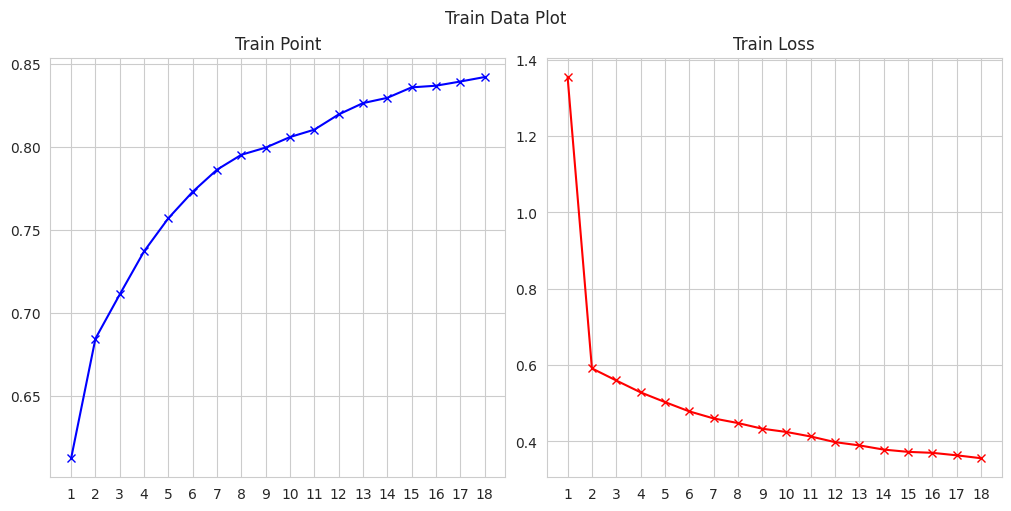

In [ ]:
from Helper import Histplot, Tensolite

hist = Histplot(model_hist, "binary_accuracy")

hist.Trainplot()

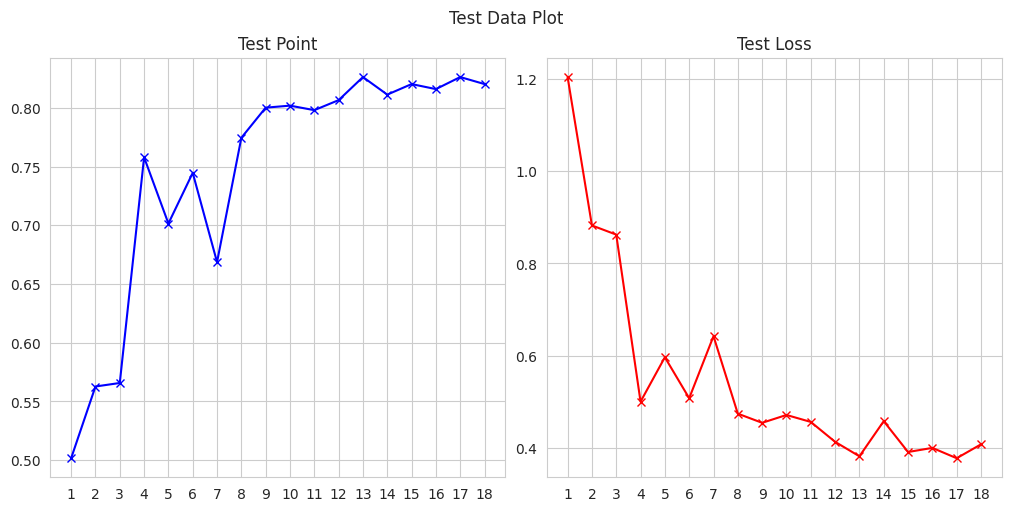

In [ ]:
hist.Testiplot()

In [ ]:
filemega = lambda filepath : os.path.getsize(filepath) / float(2**20)

optm = [tf.lite.Optimize.DEFAULT]

tflite_model = Tensolite(model, optm=optm, filename="normal_model")

round(filemega("/content/normal_model.tflite"), 3)

20.634

In [ ]:
import pathlib

lite = tf.lite.TFLiteConverter

dataset = tf.data.Dataset

train_image, train_label = next(iter(train))

def representative_data_gen():
  for input_value in dataset.from_tensor_slices(train_image).batch(1).take(100):
    yield [input_value]

tflite_model = lite.from_keras_model(model)

tflite_model.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model.representative_dataset = representative_data_gen

In [ ]:
tflite_model.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

tflite_model.inference_input_type = tf.uint8

tflite_model.inference_output_type = tf.uint8

In [ ]:
tflite_model_quant = tflite_model.convert()

tflite_model_file = pathlib.Path("quant_lite.tflite")

tflite_model_file.write_bytes(tflite_model_quant)

In [ ]:
round(filemega("/content/quant_lite.tflite"), 3)

5.173